# 批量归一化
:label:`sec_batch_norm`

训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。
在本节中，我们将介绍 *批量归一化*（batch normalization） :cite:`Ioffe.Szegedy.2015` ，这是一种流行且有效的技术，可持续加速深层网络的收敛速度。
再结合在 :numref:`sec_resnet` 中将介绍的残差块，批量归一化使得研究人员能够训练 100 层以上的网络。

## 训练深层网络

为什么需要批量归一化层呢？让我们来回顾一下训练神经网络时出现的一些实际挑战。

首先，数据预处理的方式通常会对最终结果产生巨大影响。
回想一下我们应用多层感知机来预测房价的例子（ :numref:`sec_kaggle_house` ）。
使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。
直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。

第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。
批量归一化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。
直观地说，我们可能会猜想，如果一个层的可变值是另一层的 100 倍，这可能需要对学习率进行补偿调整。

第三，更深层的网络很复杂，容易过拟合。
这意味着正则化变得更加重要。

批量归一化应用于单个可选层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先归一化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。
接下来，我们应用比例系数和比例偏移。
正是由于这个基于*批量*统计的*标准化*，才有了*批量归一化*的名称。

请注意，如果我们尝试使用大小为 1 的小批量应用批量归一化，我们将无法学到任何东西。
这是因为在减去均值之后，每个隐藏单元将为 0。
所以，只有使用足够大的小批量，批量归一化这种方法才是有效且稳定的。
请注意，在应用批量归一化时，批量大小的选择可能比没有批量归一化时更重要。

从形式上来说，用 $\mathbf{x} \in \mathcal{B}$ 表示一个来自小批量 $\mathcal{B}$ 的输入，批量归一化 $\mathrm{BN}$ 根据以下表达式转换 $\mathbf{x}$：

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

在 :eqref:`eq_batchnorm` 中，$\hat{\boldsymbol{\mu}}_\mathcal{B}$ 是样本均值，$\hat{\boldsymbol{\sigma}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本标准差。
应用标准化后，生成的小批量的平均值为 0 和单位方差为 1。
由于单位方差（与其他一些魔法数）是一个任意的选择，因此我们通常包含
*拉伸参数*（scale） $\boldsymbol{\gamma}$ 和 *偏移参数*（shift） $\boldsymbol{\beta}$，它们的形状与 $\mathbf{x}$ 相同。
请注意，$\boldsymbol{\gamma}$ 和 $\boldsymbol{\beta}$ 是需要与其他模型参数一起学习的参数。

由于在训练过程中，中间层的变化幅度不能过于剧烈，而批量归一化将每一层主动居中，并将它们重新调整为给定的平均值和大小（通过 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$）。

从形式上来看，我们计算出 :eqref:`eq_batchnorm` 中的 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$，如下所示：

$$\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}$$

请注意，我们在方差估计值中添加一个小常量 $\epsilon > 0$，以确保我们永远不会尝试除以零，即使在经验方差估计值可能消失的情况下也是如此。估计值 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 和 ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ 通过使用平均值和方差的噪声（noise）估计来抵消缩放问题。
你可能会认为这种噪声是一个问题，而事实上它是有益的。

事实证明，这是深度学习中一个反复出现的主题。
由于理论上尚未明确表述的原因，优化中的各种噪声源通常会导致更快的训练和较少的过拟合：这种变化似乎是正则化的一种形式。
在一些初步研究中， :cite:`Teye.Azizpour.Smith.2018` 和 :cite:`Luo.Wang.Shao.ea.2018` 分别将批量归一化的性质与贝叶斯先验相关联。
这些理论揭示了为什么批量归一化最适应 $50 \sim 100$ 范围中的中等小批量尺寸的难题。

另外，批量归一化图层在”训练模式“（通过小批量统计数据归一化）和“预测模式”（通过数据集统计归一化）中的功能不同。
在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。
而在预测模式下，可以根据整个数据集精确计算批量归一化所需的平均值和方差。

现在，我们了解一下批量归一化在实践中是如何工作的。


## 批量归一化层

回想一下，批量归一化和其他图层之间的一个关键区别是，由于批量归一化在完整的小批次上运行，因此我们不能像以前在引入其他图层时那样忽略批处理的尺寸大小。
我们在下面讨论这两种情况：全连接层和卷积层，他们的批量归一化实现略有不同。


### 全连接层

通常，我们将批量归一化层置于全连接层中的仿射变换和激活函数之间。
设全连接层的输入为 u ，权重参数和偏置参数分别为 $\mathbf{W}$ 和 $\mathbf{b}$ ，激活函数为 $\phi$ ，批量归一化的运算符为 $\mathrm{BN}$ 。
那么，使用批量归一化的全连接层的输出的计算详情如下：

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

回想一下，均值和方差是在应用变换的"相同"小批量上计算的。


### 卷积层

同样，对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量归一化。
当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量归一化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。
假设我们的微批次包含 $m$ 个示例，并且对于每个通道，卷积的输出具有高度 $p$ 和宽度 $q$。
那么对于卷积层，我们在每个输出通道的 $m \cdot p \cdot q$ 个元素上同时执行每个批量归一化。
因此，在计算平均值和方差时，我们会收集所有空间位置的值，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行归一化。


### 预测过程中的批量归一化

正如我们前面提到的，批量归一化在训练模式和预测模式下的行为通常不同。
首先，将训练好的模型用于预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。
其次，例如，我们可能需要使用我们的模型对逐个样本进行预测。
一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。
可见，和 dropout 一样，批量归一化层在训练模式和预测模式下的计算结果也是不一样的。



## (**从零实现**)

下面，我们从头开始实现一个具有张量的批量归一化层。


In [1]:
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过 `autograd` 来判断当前模式是训练模式还是预测模式
    if not autograd.is_training():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(axis=0)
            var = ((X - mean)**2).mean(axis=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean)**2).mean(axis=(0, 2, 3), keepdims=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / np.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean, moving_var

我们现在可以[**创建一个正确的 `BatchNorm` 图层**]。
这个层将保持适当的参数：拉伸 `gamma` 和偏移 `beta`, 这两个参数将在训练过程中更新。
此外，我们的图层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。

撇开算法细节，注意我们实现图层的基础设计模式。
通常情况下，我们用一个单独的函数定义其数学原理，比如说 `batch_norm`。
然后，我们将此功能集成到一个自定义层中，其代码主要处理簿记问题，例如将数据移动到训练设备（如 GPU）、分配和初始化任何必需的变量、跟踪移动平均线（此处为均值和方差）等。
为了方便起见，我们并不担心在这里自动推断输入形状，因此我们需要指定整个特征的数量。
不用担心，深度学习框架中的批量归一化 API 将为我们解决上述问题，我们稍后将展示这一点。


In [2]:
class BatchNorm(nn.Block):
    # `num_features`：完全连接层的输出数量或卷积层的输出通道数。
    # `num_dims`：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims, **kwargs):
        super().__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        # 非模型参数的变量初始化为0和1
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.ones(shape)

    def forward(self, X):
        # 如果 `X` 不在内存上，将 `moving_mean` 和 `moving_var`
        # 复制到 `X` 所在显存上
        if self.moving_mean.ctx != X.ctx:
            self.moving_mean = self.moving_mean.copyto(X.ctx)
            self.moving_var = self.moving_var.copyto(X.ctx)
        # 保存更新过的 `moving_mean` 和 `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-12, momentum=0.9)
        return Y

##  使用批量归一化层的 LeNet

为了更好理解如何[**应用`BatchNorm`**]，下面我们将其应用(**于LeNet模型**)（ :numref:`sec_lenet` ）。
回想一下，批量归一化是在卷积层或全连接层之后、相应的激活函数之前应用的。


In [3]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5), BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'), nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5), BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'), nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120), BatchNorm(120, num_dims=2), nn.Activation('sigmoid'),
        nn.Dense(84), BatchNorm(84, num_dims=2), nn.Activation('sigmoid'),
        nn.Dense(10))

和以前一样，我们将[**在Fashion-MNIST数据集上训练网络**]。
这个代码与我们第一次训练 LeNet（ :numref:`sec_lenet` ）时几乎完全相同，主要区别在于学习率大得多。


loss 0.244, train acc 0.910, test acc 0.839
13858.2 examples/sec on gpu(0)


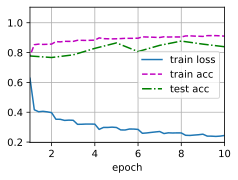

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

让我们来看看从第一个批量归一化层中学到的[**拉伸参数 `gamma` 和偏移参数 `beta`**]。


In [5]:
net[1].gamma.data().reshape(-1,), net[1].beta.data().reshape(-1,)

(array([1.8603851, 1.5551367, 2.5011127, 2.0490005, 2.1206965, 1.1736767], ctx=gpu(0)),
 array([ 1.2092065 ,  0.15372401, -3.0375447 ,  0.20894434, -0.2676465 ,
        -0.8107929 ], ctx=gpu(0)))

## [**简明实现**]

除了使用我们刚刚定义的 `BatchNorm` ，我们也可以直接使用深度学习框架中定义的 `BatchNorm` 。
该代码看起来几乎与我们上面的代码相同。


In [6]:
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5), nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Dense(120), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(84), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(10))

下面，我们[**使用相同超参数来训练模型**]。
请注意，通常高级 API 变体运行速度快得多，因为它的代码已编译为 C++ 或 CUDA，而我们的自定义代码由 Python 实现。


In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.248, train acc 0.910, test acc 0.864
24120.9 examples/sec on gpu(0)


## 争议

直观地说，批量归一化被认为可以使优化更加平滑。
然而，我们必须小心区分投机直觉和对我们观察到的现象的真实解释。
回想一下，我们甚至不知道为什么简单的神经网络（多层感知机和传统的卷积神经网络）为什么如此有效。
即使在 dropout 和权重衰减的情况下，它们仍然非常灵活，因此无法通过传统的学习理论泛化保证来解释它们是否能够概括到看不见的数据。

在提出批量归一化的论文中，作者除了介绍了其应用，还解释了其原理：通过减少 *内部协变量偏移*（internal covariate shift）。
据推测，作者所说的“内部协变量转移”类似于上述的投机直觉，即变量值的分布在训练过程中会发生变化。
然而，这种解释有两个问题：
i）这种偏移与严格定义的 *协变量偏移*（covariate shift）非常不同，所以这个名字用词不当。
ii）这种解释只提供了一种不明确的直觉，但留下了一个有待后续挖掘的问题：为什么这项技术如此有效？。
本书旨在传达实践者用来发展深层神经网络的直觉。
然而，重要的是将这些指导性直觉与既定的科学事实区分开来。
最终，当你掌握了这些方法，并开始撰写自己的研究论文时，你会希望清楚地区分技术和直觉。

随着批量归一化的普及，“内部协变量偏移”的解释反复出现在技术文献的辩论，特别是关于“如何展示机器学习研究”的更广泛的讨论中。
Ali Rahimi 在接受 2017 年 NeurIPS 大会的“接受时间考验奖”（Test of Time Award）时发表了一篇令人难忘的演讲。他将“内部协变量转移”作为焦点，将现代深度学习的实践比作炼金术。
他对该示例进行了详细回顾 :cite:`Lipton.Steinhardt.2018` ，概述了机器学习中令人不安的趋势。
此外，一些作者对批量归一化的成功提出了另一种解释：在某些方面，批量归一化的表现出与原始论文 :cite:`Santurkar.Tsipras.Ilyas.ea.2018` 中声称的行为是相反的。

然而，与技术机器学习文献中成千上万类似模糊的声明相比，内部协变量偏移没有什么更值得批评。
很可能，它作为这些辩论的焦点而产生共鸣，要归功于它对目标受众的广泛认可。
批量归一化已经证明是一种不可或缺的方法，适用于几乎所有图像分类器，在学术界获得了数万引用。



## 小结

* 在模型训练过程中，批量归一化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。
* 批量归一化在全连接层和卷积层的使用略有不同。
* 批量归一化层和 dropout 层一样，在训练模式和预测模式下计算不同。
* 批量归一化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。


## 练习

1. 在使用批量归一化之前，我们是否可以从全连接层或卷积层中删除偏置参数？为什么？
1. 比较LeNet在使用和不使用批量归一化情况下的学习率。
    1. 绘制训练和测试准确度的提高。
    1. 你的学习率有多高？
1. 我们是否需要在每个层中进行批量归一化？尝试一下？
1. 你可以通过批量归一化来替换 dropout 吗？行为如何改变？
1. 确定参数 `beta` 和 `gamma`，并观察和分析结果。
1. 查看高级 API 中有关 `BatchNorm` 的在线文档，以查看其他批量归一化的应用。
1. 研究思路：想想你可以应用的其他“归一化”转换？你可以应用概率积分变换吗？全秩协方差估计如何？


[Discussions](https://discuss.d2l.ai/t/1876)
